In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime 
from datetime import date
import math

In [2]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [3]:
data = pd.read_excel('VNM Historical Data Refine.xlsx')
# data['Date'] = pd.to_datetime(data['Date']).dt.date # cái này cũ rồi những mà vẫn để, để sau biết là có cái này để mà sài :3
data.head()

,Date,Price,Open,High,Low,Vol,Change %
0,2018-01-02,165933.0,166750.0,168876.0,164298.0,541520,-0.25%
1,2018-01-03,160211.0,160211.0,162663.0,160211.0,879470,0.00%
2,2018-01-06,137487.0,135689.0,138305.0,135280.0,1260000,2.44%
3,2018-01-08,137604.0,138511.0,138676.0,137357.0,821720,-0.77%
4,2018-01-10,105803.0,106191.0,106346.0,105570.0,617780,-0.73%


Có nên để Date không ta chứ thấy vướng quá :v

In [4]:
data = data["Price"] # mình cẫn mỗi Price thui nên là lấy Price và drop hết các cột khác luôn 
data = data.dropna()
data = data.reset_index(drop = True)# reset lại Index cho chắc

In [5]:
data.head()# trông có vẻ ổn hơn rồi á :3

0    165933.0
1    160211.0
2    137487.0
3    137604.0
4    105803.0
Name: Price, dtype: float64

In [6]:
print('There are {} number of days in the dataset.'.format(data.shape[0]))

There are 1434 number of days in the dataset.


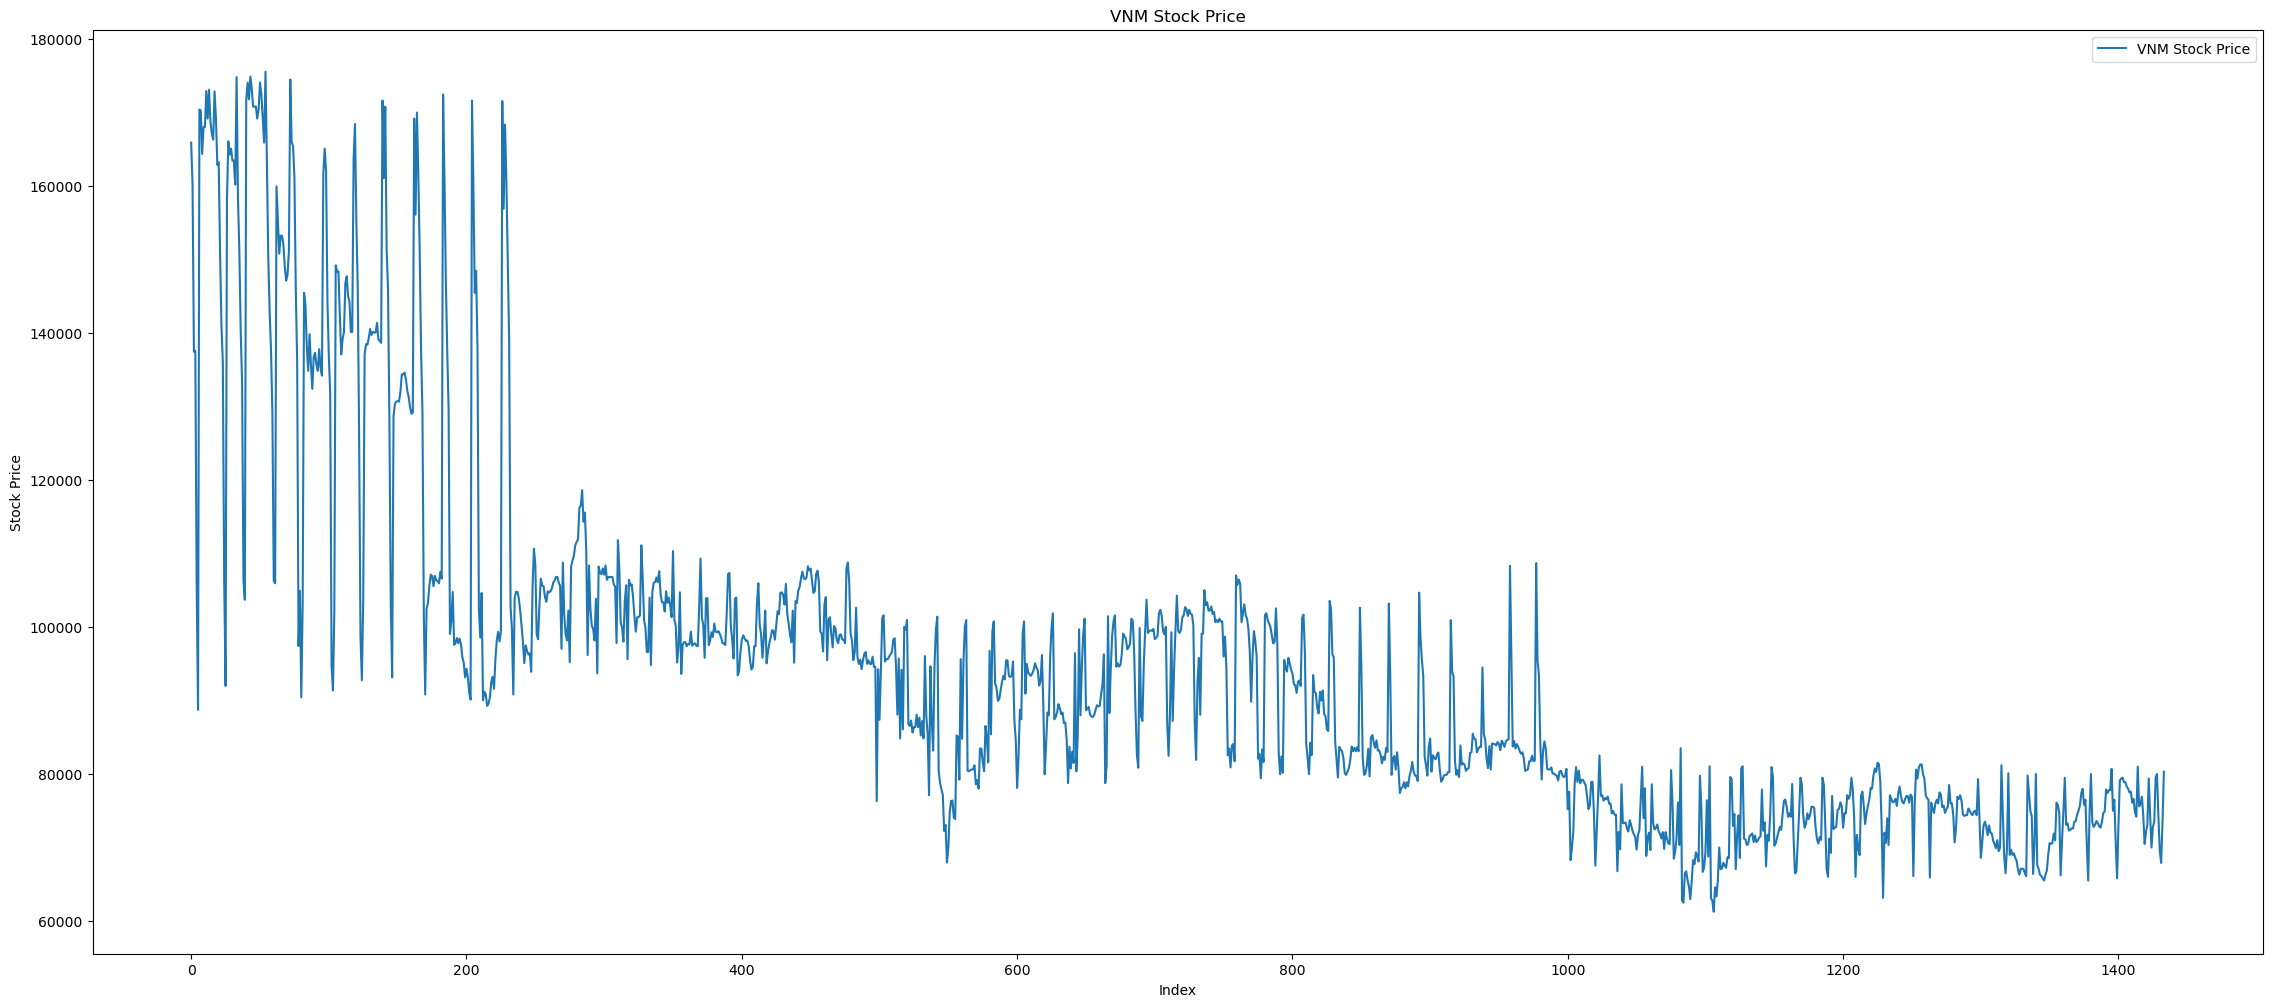

In [7]:
plt.figure(figsize=(28, 12))#, dpi=100)
plt.plot(data, label='VNM Stock Price')
plt.xlabel('Index')
plt.ylabel('Stock Price')
plt.title('VNM Stock Price')
plt.legend()
plt.show()

In [8]:
# Scale data 
scaler=MinMaxScaler(feature_range=(0,1))
data=scaler.fit_transform(np.array(data).reshape(-1,1))

In [9]:
# chia tỉ lệ 6:2:2 train:test:val
train_size = int(0.6 * len(data))
test_size = int(0.2 * len(data))
val_size = len(data) - train_size - test_size

train_data = data[:train_size]
test_data = data[train_size:train_size+test_size]
val_data = data[train_size+test_size:]

Đôi lời một chút thì người ta khuyến khích sài hàm train_test_split để tạo được độ random cho data và tăng độ chính xác out-of-sample nhưng mà cảm thấy khó sài và sau khi bung bét với ARIMA thì quyết định quay trờ lại làm tuyến tính như bình thường

In [10]:
# def get_technical_indicators(dataset):
#     # Create 7 and 21 days Moving Average
#     dataset['ma7'] = dataset['Price'].rolling(window=7).mean()
#     dataset['ma21'] = dataset['Price'].rolling(window=21).mean()
    
#     # Create MACD
#     dataset['26ema'] = dataset['Price'].ewm(span=26).mean()
#     dataset['12ema'] = dataset['Price'].ewm(span=12).mean()
#     dataset['MACD'] = dataset['12ema']-dataset['26ema']

#     # Create Bollinger Bands
#     dataset['20sd'] = dataset['Price'].rolling(window = 21).std()
#     dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
#     dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
    
#     # Create Exponential moving average
#     dataset['ema'] = dataset['Price'].ewm(com=0.5).mean()
    
#     # Create Momentum
#     dataset['momentum'] = dataset['Price']-1
#     dataset['log_momentum'] = np.log(dataset['momentum'])
#     return dataset

In [11]:
# df = get_technical_indicators(data)

In [12]:
# def plot_technical_indicators(dataset, last_days):
#     plt.figure(figsize=(16, 10), dpi=100)
#     shape_0 = dataset.shape[0]
#     xmacd_ = shape_0-last_days
    
#     dataset = dataset.iloc[-last_days:, :]
#     x_ = range(3, dataset.shape[0])
#     x_ =list(dataset.index)

#     plt.figure(figsize=(30,20))
#     # Plot first subplot
#     plt.subplot(2, 1, 1)
#     plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
#     plt.plot(dataset['Price'],label='Closing Price', color='b')
#     plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
#     plt.plot(dataset['upper_band'],label='Upper Band', color='c')
#     plt.plot(dataset['lower_band'],label='Lower Band', color='c')
#     plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
#     plt.title('Technical indicators for VNM - last {} days.'.format(last_days))
#     plt.ylabel('VND')
#     plt.legend()
    
#     plt.subplot(2, 1, 2)
#     plt.title('MACD')
#     plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
# #     plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
# #     plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
#     plt.plot(dataset['log_momentum'],label='Momentum', color='b',linestyle='-')

#     plt.legend()
#     plt.show()
    

In [13]:
# plot_technical_indicators(df,1000)

mấy cái này là thông số của stock dành cho các nhà đầu tư nhìn vào 

In [14]:
# plt.figure(figsize = (28,12))
# sns.set_context('poster',font_scale=1)
# sns.heatmap(df.corr(), annot = True).set_title('Params')

Tới lúc tạo model LSTM nào

In [15]:
#Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
# chuyển mảng một chiều sang mảng đa chiều 
# để có thể dễ dàng trong việc phân chia input và ouput cho việc phát triển model LSTM
# hay nói một cách đơn giản input để train và output để predict (thuật ngữ chuyên môn là mapping)
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [16]:
#   Phân chia tiếp để train model
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [17]:
#  Reshape lại input thành [samples, time steps, features] để nạp vào LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [18]:
from keras.layers import Dense, SimpleRNN

In [19]:
#  Tạo LSTM Model
model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [35]:
#  Training timee
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=1000,batch_size=64,verbose=1)

Epoch 1/1000
12/12 [==============================] - 0s 13ms/step - loss: 3.1852e-04 - val_loss: 73548188757564325888.0000
Epoch 2/1000
12/12 [==============================] - 1s 47ms/step - loss: 4.5376e-04 - val_loss: 73548188757564325888.0000
Epoch 3/1000
12/12 [==============================] - 0s 26ms/step - loss: 4.3192e-04 - val_loss: 73548188757564325888.0000
Epoch 4/1000
12/12 [==============================] - 0s 12ms/step - loss: 4.3849e-04 - val_loss: 73548188757564325888.0000
Epoch 5/1000
12/12 [==============================] - 0s 11ms/step - loss: 3.6268e-04 - val_loss: 73548188757564325888.0000
Epoch 6/1000
12/12 [==============================] - 0s 12ms/step - loss: 4.2909e-04 - val_loss: 73548188757564325888.0000
Epoch 7/1000
12/12 [==============================] - 0s 15ms/step - loss: 6.5649e-04 - val_loss: 73548188757564325888.0000
Epoch 8/1000
12/12 [==============================] - 0s 28ms/step - loss: 6.8640e-04 - val_loss: 73548188757564325888.0000
Epoch 9/

12/12 [==============================] - 0s 15ms/step - loss: 3.8588e-04 - val_loss: 73548188757564325888.0000
Epoch 67/1000
12/12 [==============================] - 0s 19ms/step - loss: 3.3234e-04 - val_loss: 73548188757564325888.0000
Epoch 68/1000
12/12 [==============================] - 0s 39ms/step - loss: 4.0969e-04 - val_loss: 73548188757564325888.0000
Epoch 69/1000
12/12 [==============================] - 0s 20ms/step - loss: 3.8899e-04 - val_loss: 73548188757564325888.0000
Epoch 70/1000
12/12 [==============================] - 0s 13ms/step - loss: 3.0699e-04 - val_loss: 73548188757564325888.0000
Epoch 71/1000
12/12 [==============================] - 0s 12ms/step - loss: 3.1049e-04 - val_loss: 73548188757564325888.0000
Epoch 72/1000
12/12 [==============================] - 0s 12ms/step - loss: 3.1344e-04 - val_loss: 73548188757564325888.0000
Epoch 73/1000
12/12 [==============================] - 0s 15ms/step - loss: 3.2966e-04 - val_loss: 73548188757564325888.0000
Epoch 74/1000


12/12 [==============================] - 0s 24ms/step - loss: 3.1797e-04 - val_loss: 73548188757564325888.0000
Epoch 132/1000
12/12 [==============================] - 0s 27ms/step - loss: 3.0807e-04 - val_loss: 73548188757564325888.0000
Epoch 133/1000
12/12 [==============================] - 0s 21ms/step - loss: 2.8127e-04 - val_loss: 73548188757564325888.0000
Epoch 134/1000
12/12 [==============================] - 0s 15ms/step - loss: 3.1188e-04 - val_loss: 73548188757564325888.0000
Epoch 135/1000
12/12 [==============================] - 0s 13ms/step - loss: 3.0809e-04 - val_loss: 73548188757564325888.0000
Epoch 136/1000
12/12 [==============================] - 0s 14ms/step - loss: 2.4991e-04 - val_loss: 73548188757564325888.0000
Epoch 137/1000
12/12 [==============================] - 0s 13ms/step - loss: 2.2621e-04 - val_loss: 73548188757564325888.0000
Epoch 138/1000
12/12 [==============================] - 0s 16ms/step - loss: 2.7947e-04 - val_loss: 73548188757564325888.0000
Epoch 1

12/12 [==============================] - 0s 17ms/step - loss: 3.1586e-04 - val_loss: 73548188757564325888.0000
Epoch 197/1000
12/12 [==============================] - 0s 18ms/step - loss: 3.8471e-04 - val_loss: 73548188757564325888.0000
Epoch 198/1000
12/12 [==============================] - 0s 18ms/step - loss: 4.3868e-04 - val_loss: 73548188757564325888.0000
Epoch 199/1000
12/12 [==============================] - 0s 21ms/step - loss: 5.3054e-04 - val_loss: 73548188757564325888.0000
Epoch 200/1000
12/12 [==============================] - 0s 27ms/step - loss: 5.1821e-04 - val_loss: 73548188757564325888.0000
Epoch 201/1000
12/12 [==============================] - 1s 46ms/step - loss: 3.9610e-04 - val_loss: 73548188757564325888.0000
Epoch 202/1000
12/12 [==============================] - 0s 23ms/step - loss: 3.8677e-04 - val_loss: 73548188757564325888.0000
Epoch 203/1000
12/12 [==============================] - 0s 16ms/step - loss: 3.3654e-04 - val_loss: 73548188757564325888.0000
Epoch 2

12/12 [==============================] - 0s 12ms/step - loss: 2.4294e-04 - val_loss: 73548188757564325888.0000
Epoch 262/1000
12/12 [==============================] - 0s 38ms/step - loss: 2.3890e-04 - val_loss: 73548188757564325888.0000
Epoch 263/1000
12/12 [==============================] - 1s 43ms/step - loss: 2.6762e-04 - val_loss: 73548188757564325888.0000
Epoch 264/1000
12/12 [==============================] - 0s 17ms/step - loss: 2.0424e-04 - val_loss: 73548188757564325888.0000
Epoch 265/1000
12/12 [==============================] - 0s 17ms/step - loss: 1.9840e-04 - val_loss: 73548188757564325888.0000
Epoch 266/1000
12/12 [==============================] - 0s 19ms/step - loss: 2.6306e-04 - val_loss: 73548188757564325888.0000
Epoch 267/1000
12/12 [==============================] - 0s 20ms/step - loss: 2.6875e-04 - val_loss: 73548188757564325888.0000
Epoch 268/1000
12/12 [==============================] - 0s 20ms/step - loss: 2.7424e-04 - val_loss: 73548188757564325888.0000
Epoch 2

12/12 [==============================] - 0s 17ms/step - loss: 3.3220e-04 - val_loss: 73548188757564325888.0000
Epoch 327/1000
12/12 [==============================] - 0s 16ms/step - loss: 2.7092e-04 - val_loss: 73548188757564325888.0000
Epoch 328/1000
12/12 [==============================] - 0s 15ms/step - loss: 2.4565e-04 - val_loss: 73548188757564325888.0000
Epoch 329/1000
12/12 [==============================] - 0s 15ms/step - loss: 2.9325e-04 - val_loss: 73548188757564325888.0000
Epoch 330/1000
12/12 [==============================] - 0s 14ms/step - loss: 2.7940e-04 - val_loss: 73548188757564325888.0000
Epoch 331/1000
12/12 [==============================] - 0s 15ms/step - loss: 2.4075e-04 - val_loss: 73548188757564325888.0000
Epoch 332/1000
12/12 [==============================] - 0s 16ms/step - loss: 1.9620e-04 - val_loss: 73548188757564325888.0000
Epoch 333/1000
12/12 [==============================] - 0s 17ms/step - loss: 1.7859e-04 - val_loss: 73548188757564325888.0000
Epoch 3

12/12 [==============================] - 1s 49ms/step - loss: 3.1443e-04 - val_loss: 73548188757564325888.0000
Epoch 392/1000
12/12 [==============================] - 0s 18ms/step - loss: 2.8807e-04 - val_loss: 73548188757564325888.0000
Epoch 393/1000
12/12 [==============================] - 0s 11ms/step - loss: 2.6500e-04 - val_loss: 73548188757564325888.0000
Epoch 394/1000
12/12 [==============================] - 0s 12ms/step - loss: 2.5721e-04 - val_loss: 73548188757564325888.0000
Epoch 395/1000
12/12 [==============================] - 0s 18ms/step - loss: 2.0167e-04 - val_loss: 73548188757564325888.0000
Epoch 396/1000
12/12 [==============================] - 1s 62ms/step - loss: 1.9604e-04 - val_loss: 73548188757564325888.0000
Epoch 397/1000
12/12 [==============================] - 0s 15ms/step - loss: 1.7007e-04 - val_loss: 73548188757564325888.0000
Epoch 398/1000
12/12 [==============================] - 0s 12ms/step - loss: 1.6448e-04 - val_loss: 73548188757564325888.0000
Epoch 3

12/12 [==============================] - 0s 18ms/step - loss: 2.8620e-04 - val_loss: 73548188757564325888.0000
Epoch 457/1000
12/12 [==============================] - 0s 16ms/step - loss: 3.5593e-04 - val_loss: 73548188757564325888.0000
Epoch 458/1000
12/12 [==============================] - 0s 13ms/step - loss: 3.2561e-04 - val_loss: 73548188757564325888.0000
Epoch 459/1000
12/12 [==============================] - 0s 13ms/step - loss: 4.0961e-04 - val_loss: 73548188757564325888.0000
Epoch 460/1000
12/12 [==============================] - 0s 13ms/step - loss: 3.5469e-04 - val_loss: 73548188757564325888.0000
Epoch 461/1000
12/12 [==============================] - 0s 15ms/step - loss: 2.9281e-04 - val_loss: 73548188757564325888.0000
Epoch 462/1000
12/12 [==============================] - 0s 22ms/step - loss: 2.7674e-04 - val_loss: 73548188757564325888.0000
Epoch 463/1000
12/12 [==============================] - 1s 52ms/step - loss: 2.2203e-04 - val_loss: 73548188757564325888.0000
Epoch 4

12/12 [==============================] - 0s 14ms/step - loss: 2.7063e-04 - val_loss: 73548188757564325888.0000
Epoch 522/1000
12/12 [==============================] - 0s 18ms/step - loss: 3.0571e-04 - val_loss: 73548188757564325888.0000
Epoch 523/1000
12/12 [==============================] - 0s 23ms/step - loss: 2.7779e-04 - val_loss: 73548188757564325888.0000
Epoch 524/1000
12/12 [==============================] - 0s 17ms/step - loss: 2.3638e-04 - val_loss: 73548188757564325888.0000
Epoch 525/1000
12/12 [==============================] - 0s 13ms/step - loss: 2.4308e-04 - val_loss: 73548188757564325888.0000
Epoch 526/1000
12/12 [==============================] - 0s 14ms/step - loss: 2.0879e-04 - val_loss: 73548188757564325888.0000
Epoch 527/1000
12/12 [==============================] - 0s 18ms/step - loss: 2.0595e-04 - val_loss: 73548188757564325888.0000
Epoch 528/1000
12/12 [==============================] - 1s 55ms/step - loss: 1.6239e-04 - val_loss: 73548188757564325888.0000
Epoch 5

12/12 [==============================] - 0s 13ms/step - loss: 2.1486e-04 - val_loss: 73548188757564325888.0000
Epoch 587/1000
12/12 [==============================] - 0s 10ms/step - loss: 2.3395e-04 - val_loss: 73548188757564325888.0000
Epoch 588/1000
12/12 [==============================] - 0s 11ms/step - loss: 2.0855e-04 - val_loss: 73548188757564325888.0000
Epoch 589/1000
12/12 [==============================] - 1s 66ms/step - loss: 2.1833e-04 - val_loss: 73548188757564325888.0000
Epoch 590/1000
12/12 [==============================] - 0s 16ms/step - loss: 2.4229e-04 - val_loss: 73548188757564325888.0000
Epoch 591/1000
12/12 [==============================] - 0s 13ms/step - loss: 2.6233e-04 - val_loss: 73548188757564325888.0000
Epoch 592/1000
12/12 [==============================] - 0s 14ms/step - loss: 1.8422e-04 - val_loss: 73548188757564325888.0000
Epoch 593/1000
12/12 [==============================] - 0s 16ms/step - loss: 1.4797e-04 - val_loss: 73548188757564325888.0000
Epoch 5

12/12 [==============================] - 0s 13ms/step - loss: 4.3412e-04 - val_loss: 73548188757564325888.0000
Epoch 652/1000
12/12 [==============================] - 0s 12ms/step - loss: 3.6384e-04 - val_loss: 73548188757564325888.0000
Epoch 653/1000
12/12 [==============================] - 0s 12ms/step - loss: 3.2385e-04 - val_loss: 73548188757564325888.0000
Epoch 654/1000
12/12 [==============================] - 0s 13ms/step - loss: 2.8162e-04 - val_loss: 73548188757564325888.0000
Epoch 655/1000
12/12 [==============================] - 0s 16ms/step - loss: 2.5956e-04 - val_loss: 73548188757564325888.0000
Epoch 656/1000
12/12 [==============================] - 0s 28ms/step - loss: 2.4556e-04 - val_loss: 73548188757564325888.0000
Epoch 657/1000
12/12 [==============================] - 1s 54ms/step - loss: 2.2879e-04 - val_loss: 73548188757564325888.0000
Epoch 658/1000
12/12 [==============================] - 0s 17ms/step - loss: 2.1996e-04 - val_loss: 73548188757564325888.0000
Epoch 6

12/12 [==============================] - 0s 15ms/step - loss: 1.4277e-04 - val_loss: 73548188757564325888.0000
Epoch 717/1000
12/12 [==============================] - 0s 16ms/step - loss: 1.3537e-04 - val_loss: 73548188757564325888.0000
Epoch 718/1000
12/12 [==============================] - 0s 17ms/step - loss: 1.4260e-04 - val_loss: 73548188757564325888.0000
Epoch 719/1000
12/12 [==============================] - 0s 18ms/step - loss: 1.8308e-04 - val_loss: 73548188757564325888.0000
Epoch 720/1000
12/12 [==============================] - 0s 18ms/step - loss: 1.9738e-04 - val_loss: 73548188757564325888.0000
Epoch 721/1000
12/12 [==============================] - 0s 17ms/step - loss: 1.6224e-04 - val_loss: 73548188757564325888.0000
Epoch 722/1000
12/12 [==============================] - 0s 14ms/step - loss: 1.6977e-04 - val_loss: 73548188757564325888.0000
Epoch 723/1000
12/12 [==============================] - 0s 13ms/step - loss: 1.4553e-04 - val_loss: 73548188757564325888.0000
Epoch 7

12/12 [==============================] - 0s 14ms/step - loss: 3.1051e-04 - val_loss: 73548188757564325888.0000
Epoch 782/1000
12/12 [==============================] - 0s 14ms/step - loss: 2.9119e-04 - val_loss: 73548188757564325888.0000
Epoch 783/1000
12/12 [==============================] - 0s 16ms/step - loss: 3.3664e-04 - val_loss: 73548188757564325888.0000
Epoch 784/1000
12/12 [==============================] - 0s 20ms/step - loss: 3.8597e-04 - val_loss: 73548188757564325888.0000
Epoch 785/1000
12/12 [==============================] - 0s 19ms/step - loss: 3.6254e-04 - val_loss: 73548188757564325888.0000
Epoch 786/1000
12/12 [==============================] - 0s 15ms/step - loss: 2.5126e-04 - val_loss: 73548188757564325888.0000
Epoch 787/1000
12/12 [==============================] - 0s 13ms/step - loss: 2.2811e-04 - val_loss: 73548188757564325888.0000
Epoch 788/1000
12/12 [==============================] - 0s 13ms/step - loss: 1.9618e-04 - val_loss: 73548188757564325888.0000
Epoch 7

12/12 [==============================] - 0s 17ms/step - loss: 1.4510e-04 - val_loss: 73548188757564325888.0000
Epoch 847/1000
12/12 [==============================] - 0s 14ms/step - loss: 1.6348e-04 - val_loss: 73548188757564325888.0000
Epoch 848/1000
12/12 [==============================] - 0s 14ms/step - loss: 1.0655e-04 - val_loss: 73548188757564325888.0000
Epoch 849/1000
12/12 [==============================] - 0s 14ms/step - loss: 1.0146e-04 - val_loss: 73548188757564325888.0000
Epoch 850/1000
12/12 [==============================] - 0s 14ms/step - loss: 8.8591e-05 - val_loss: 73548188757564325888.0000
Epoch 851/1000
12/12 [==============================] - 0s 17ms/step - loss: 6.9200e-05 - val_loss: 73548188757564325888.0000
Epoch 852/1000
12/12 [==============================] - 0s 20ms/step - loss: 6.7936e-05 - val_loss: 73548188757564325888.0000
Epoch 853/1000
12/12 [==============================] - 0s 20ms/step - loss: 7.2694e-05 - val_loss: 73548188757564325888.0000
Epoch 8

12/12 [==============================] - 0s 12ms/step - loss: 1.9941e-04 - val_loss: 73548188757564325888.0000
Epoch 912/1000
12/12 [==============================] - 0s 13ms/step - loss: 2.6543e-04 - val_loss: 73548188757564325888.0000
Epoch 913/1000
12/12 [==============================] - 1s 61ms/step - loss: 3.2745e-04 - val_loss: 73548188757564325888.0000
Epoch 914/1000
12/12 [==============================] - 0s 12ms/step - loss: 3.4133e-04 - val_loss: 73548188757564325888.0000
Epoch 915/1000
12/12 [==============================] - 0s 12ms/step - loss: 2.9904e-04 - val_loss: 73548188757564325888.0000
Epoch 916/1000
12/12 [==============================] - 0s 13ms/step - loss: 2.9575e-04 - val_loss: 73548188757564325888.0000
Epoch 917/1000
12/12 [==============================] - 0s 32ms/step - loss: 3.4170e-04 - val_loss: 73548188757564325888.0000
Epoch 918/1000
12/12 [==============================] - 0s 31ms/step - loss: 3.2786e-04 - val_loss: 73548188757564325888.0000
Epoch 9

12/12 [==============================] - 0s 16ms/step - loss: 2.7957e-04 - val_loss: 73548188757564325888.0000
Epoch 977/1000
12/12 [==============================] - 0s 16ms/step - loss: 2.3969e-04 - val_loss: 73548188757564325888.0000
Epoch 978/1000
12/12 [==============================] - 0s 17ms/step - loss: 2.5306e-04 - val_loss: 73548188757564325888.0000
Epoch 979/1000
12/12 [==============================] - 0s 17ms/step - loss: 1.8244e-04 - val_loss: 73548188757564325888.0000
Epoch 980/1000
12/12 [==============================] - 0s 17ms/step - loss: 1.8113e-04 - val_loss: 73548188757564325888.0000
Epoch 981/1000
12/12 [==============================] - 0s 18ms/step - loss: 2.0141e-04 - val_loss: 73548188757564325888.0000
Epoch 982/1000
12/12 [==============================] - 0s 19ms/step - loss: 1.6278e-04 - val_loss: 73548188757564325888.0000
Epoch 983/1000
12/12 [==============================] - 0s 19ms/step - loss: 1.9261e-04 - val_loss: 73548188757564325888.0000
Epoch 9

In [36]:
#   Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

6/6 [==============================] - 0s 6ms/step


In [37]:
#  Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
ytest
yval = scaler.inverse_transform(yval.reshape(-1,1))
yval

array([[1.00628784e+15],
       [1.00628784e+15],
       [9.94526113e+14],
       [1.00890155e+15],
       [1.00498098e+15],
       [8.63840291e+14],
       [9.93219255e+14],
       [1.05333473e+15],
       [1.03765243e+15],
       [1.05725531e+15],
       [1.06248274e+15],
       [1.06248274e+15],
       [1.04549358e+15],
       [1.03765243e+15],
       [1.00759470e+15],
       [1.00236726e+15],
       [9.99753546e+14],
       [8.61226574e+14],
       [9.94526113e+14],
       [9.84071247e+14],
       [9.76230098e+14],
       [9.93219255e+14],
       [9.99753546e+14],
       [9.93219255e+14],
       [1.01282213e+15],
       [1.00890155e+15],
       [9.86684964e+14],
       [9.89298680e+14],
       [9.76230098e+14],
       [9.82764389e+14],
       [9.86684964e+14],
       [1.02589071e+15],
       [9.93219255e+14],
       [9.93219255e+14],
       [9.72309523e+14],
       [9.23955769e+14],
       [9.48786075e+14],
       [1.00498098e+15],
       [1.00106040e+15],
       [1.00759470e+15],


In [38]:
#  Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
valid_mape = np.mean(np.abs((yval - y_pred_val) / yval)) * 100
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
valid_mae = np.mean(np.abs(yval - y_pred_val))
test_mae = np.mean(np.abs(ytest - y_pred))
print(f'Validation RMSE: {valid_rmse:.2f}')
# print(f'Testing RMSE: {test_rmse:.5f}')
print(f'Validation MAPE: {valid_mape:.2f}')
# print('Testing MAPE:', test_mape)
print(f'Validation MAE: {valid_mae:.2f}')
# print('Testing MAE:', test_mae)

Validation RMSE: 966340173386630.38
Validation MAPE: 100.00
Validation MAE: 964866721093800.00


In [39]:
#  Dự báo 100 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=227
i=0
while(i<100):# đổi ở đây nhooo

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

0 day input [0.14539193 0.11216004 0.0415403  0.09147824 0.07515009 0.06741551
 0.13788479 0.14304147 0.12585343 0.10436861 0.11725985 0.12585343
 0.133588   0.14733826 0.14647925 0.16194752 0.17054197 0.16624518
 0.17741666 0.17569777 0.15453136 0.1021896  0.01661595 0.09405614
 0.08202477 0.11124417 0.07944688 0.13874468 0.13444789 0.13015022
 0.1310101  0.13444789 0.12585343 0.14046357 0.14905715 0.13768535
 0.13068732 0.12893781 0.13418633 0.13768535 0.13768535 0.12981257
 0.13943486 0.1368106  0.0423372  0.12893781 0.16917648 0.15867944
 0.17180074 0.17529976 0.17529976 0.16392796 0.15867944 0.1385601
 0.13506109 0.13331158 0.04058769 0.12981257 0.12281454 0.11756602
 0.12893781 0.13331158 0.12893781 0.14205912 0.13943486 0.12456404
 0.12631355 0.11756602 0.12193978 0.12456404 0.15080665 0.12893781
 0.12893781 0.11494175 0.08257587 0.09919619 0.1368106  0.13418633
 0.1385601  0.13243683 0.11581651 0.114067   0.11494175 0.11494175
 0.12281454 0.12019028 0.11669126 0.11494175 0.1193

6 day output [[-0.01852602]]
7 day input [ 0.14304147  0.12585343  0.10436861  0.11725985  0.12585343  0.133588
  0.14733826  0.14647925  0.16194752  0.17054197  0.16624518  0.17741666
  0.17569777  0.15453136  0.1021896   0.01661595  0.09405614  0.08202477
  0.11124417  0.07944688  0.13874468  0.13444789  0.13015022  0.1310101
  0.13444789  0.12585343  0.14046357  0.14905715  0.13768535  0.13068732
  0.12893781  0.13418633  0.13768535  0.13768535  0.12981257  0.13943486
  0.1368106   0.0423372   0.12893781  0.16917648  0.15867944  0.17180074
  0.17529976  0.17529976  0.16392796  0.15867944  0.1385601   0.13506109
  0.13331158  0.04058769  0.12981257  0.12281454  0.11756602  0.12893781
  0.13331158  0.12893781  0.14205912  0.13943486  0.12456404  0.12631355
  0.11756602  0.12193978  0.12456404  0.15080665  0.12893781  0.12893781
  0.11494175  0.08257587  0.09919619  0.1368106   0.13418633  0.1385601
  0.13243683  0.11581651  0.114067    0.11494175  0.11494175  0.12281454
  0.12019028  

10 day output [[0.10312694]]
11 day input [ 0.12585343  0.133588    0.14733826  0.14647925  0.16194752  0.17054197
  0.16624518  0.17741666  0.17569777  0.15453136  0.1021896   0.01661595
  0.09405614  0.08202477  0.11124417  0.07944688  0.13874468  0.13444789
  0.13015022  0.1310101   0.13444789  0.12585343  0.14046357  0.14905715
  0.13768535  0.13068732  0.12893781  0.13418633  0.13768535  0.13768535
  0.12981257  0.13943486  0.1368106   0.0423372   0.12893781  0.16917648
  0.15867944  0.17180074  0.17529976  0.17529976  0.16392796  0.15867944
  0.1385601   0.13506109  0.13331158  0.04058769  0.12981257  0.12281454
  0.11756602  0.12893781  0.13331158  0.12893781  0.14205912  0.13943486
  0.12456404  0.12631355  0.11756602  0.12193978  0.12456404  0.15080665
  0.12893781  0.12893781  0.11494175  0.08257587  0.09919619  0.1368106
  0.13418633  0.1385601   0.13243683  0.11581651  0.114067    0.11494175
  0.11494175  0.12281454  0.12019028  0.11669126  0.11494175  0.11931552
  0.120190

13 day output [[0.09941559]]
14 day input [ 0.14647925  0.16194752  0.17054197  0.16624518  0.17741666  0.17569777
  0.15453136  0.1021896   0.01661595  0.09405614  0.08202477  0.11124417
  0.07944688  0.13874468  0.13444789  0.13015022  0.1310101   0.13444789
  0.12585343  0.14046357  0.14905715  0.13768535  0.13068732  0.12893781
  0.13418633  0.13768535  0.13768535  0.12981257  0.13943486  0.1368106
  0.0423372   0.12893781  0.16917648  0.15867944  0.17180074  0.17529976
  0.17529976  0.16392796  0.15867944  0.1385601   0.13506109  0.13331158
  0.04058769  0.12981257  0.12281454  0.11756602  0.12893781  0.13331158
  0.12893781  0.14205912  0.13943486  0.12456404  0.12631355  0.11756602
  0.12193978  0.12456404  0.15080665  0.12893781  0.12893781  0.11494175
  0.08257587  0.09919619  0.1368106   0.13418633  0.1385601   0.13243683
  0.11581651  0.114067    0.11494175  0.11494175  0.12281454  0.12019028
  0.11669126  0.11494175  0.11931552  0.12019028  0.11494175  0.15780468
  0.113192

16 day output [[0.05396429]]
17 day input [ 0.16624518  0.17741666  0.17569777  0.15453136  0.1021896   0.01661595
  0.09405614  0.08202477  0.11124417  0.07944688  0.13874468  0.13444789
  0.13015022  0.1310101   0.13444789  0.12585343  0.14046357  0.14905715
  0.13768535  0.13068732  0.12893781  0.13418633  0.13768535  0.13768535
  0.12981257  0.13943486  0.1368106   0.0423372   0.12893781  0.16917648
  0.15867944  0.17180074  0.17529976  0.17529976  0.16392796  0.15867944
  0.1385601   0.13506109  0.13331158  0.04058769  0.12981257  0.12281454
  0.11756602  0.12893781  0.13331158  0.12893781  0.14205912  0.13943486
  0.12456404  0.12631355  0.11756602  0.12193978  0.12456404  0.15080665
  0.12893781  0.12893781  0.11494175  0.08257587  0.09919619  0.1368106
  0.13418633  0.1385601   0.13243683  0.11581651  0.114067    0.11494175
  0.11494175  0.12281454  0.12019028  0.11669126  0.11494175  0.11931552
  0.12019028  0.11494175  0.15780468  0.11319225  0.06420604  0.08170112
  0.102695

21 day output [[0.1440767]]
22 day input [ 0.01661595  0.09405614  0.08202477  0.11124417  0.07944688  0.13874468
  0.13444789  0.13015022  0.1310101   0.13444789  0.12585343  0.14046357
  0.14905715  0.13768535  0.13068732  0.12893781  0.13418633  0.13768535
  0.13768535  0.12981257  0.13943486  0.1368106   0.0423372   0.12893781
  0.16917648  0.15867944  0.17180074  0.17529976  0.17529976  0.16392796
  0.15867944  0.1385601   0.13506109  0.13331158  0.04058769  0.12981257
  0.12281454  0.11756602  0.12893781  0.13331158  0.12893781  0.14205912
  0.13943486  0.12456404  0.12631355  0.11756602  0.12193978  0.12456404
  0.15080665  0.12893781  0.12893781  0.11494175  0.08257587  0.09919619
  0.1368106   0.13418633  0.1385601   0.13243683  0.11581651  0.114067
  0.11494175  0.11494175  0.12281454  0.12019028  0.11669126  0.11494175
  0.11931552  0.12019028  0.11494175  0.15780468  0.11319225  0.06420604
  0.08170112  0.1026952   0.10706897  0.1009457   0.09132341  0.1026952
  0.09394767 

25 day output [[0.11095302]]
26 day input [ 0.07944688  0.13874468  0.13444789  0.13015022  0.1310101   0.13444789
  0.12585343  0.14046357  0.14905715  0.13768535  0.13068732  0.12893781
  0.13418633  0.13768535  0.13768535  0.12981257  0.13943486  0.1368106
  0.0423372   0.12893781  0.16917648  0.15867944  0.17180074  0.17529976
  0.17529976  0.16392796  0.15867944  0.1385601   0.13506109  0.13331158
  0.04058769  0.12981257  0.12281454  0.11756602  0.12893781  0.13331158
  0.12893781  0.14205912  0.13943486  0.12456404  0.12631355  0.11756602
  0.12193978  0.12456404  0.15080665  0.12893781  0.12893781  0.11494175
  0.08257587  0.09919619  0.1368106   0.13418633  0.1385601   0.13243683
  0.11581651  0.114067    0.11494175  0.11494175  0.12281454  0.12019028
  0.11669126  0.11494175  0.11931552  0.12019028  0.11494175  0.15780468
  0.11319225  0.06420604  0.08170112  0.1026952   0.10706897  0.1009457
  0.09132341  0.1026952   0.09394767  0.09307291  0.08432538  0.08082636
  0.0755778

29 day output [[0.08724041]]
30 day input [ 0.1310101   0.13444789  0.12585343  0.14046357  0.14905715  0.13768535
  0.13068732  0.12893781  0.13418633  0.13768535  0.13768535  0.12981257
  0.13943486  0.1368106   0.0423372   0.12893781  0.16917648  0.15867944
  0.17180074  0.17529976  0.17529976  0.16392796  0.15867944  0.1385601
  0.13506109  0.13331158  0.04058769  0.12981257  0.12281454  0.11756602
  0.12893781  0.13331158  0.12893781  0.14205912  0.13943486  0.12456404
  0.12631355  0.11756602  0.12193978  0.12456404  0.15080665  0.12893781
  0.12893781  0.11494175  0.08257587  0.09919619  0.1368106   0.13418633
  0.1385601   0.13243683  0.11581651  0.114067    0.11494175  0.11494175
  0.12281454  0.12019028  0.11669126  0.11494175  0.11931552  0.12019028
  0.11494175  0.15780468  0.11319225  0.06420604  0.08170112  0.1026952
  0.10706897  0.1009457   0.09132341  0.1026952   0.09394767  0.09307291
  0.08432538  0.08082636  0.07557784  0.08520013  0.07207883  0.07645259
  0.174425 

33 day output [[0.09704816]]
34 day input [ 0.14905715  0.13768535  0.13068732  0.12893781  0.13418633  0.13768535
  0.13768535  0.12981257  0.13943486  0.1368106   0.0423372   0.12893781
  0.16917648  0.15867944  0.17180074  0.17529976  0.17529976  0.16392796
  0.15867944  0.1385601   0.13506109  0.13331158  0.04058769  0.12981257
  0.12281454  0.11756602  0.12893781  0.13331158  0.12893781  0.14205912
  0.13943486  0.12456404  0.12631355  0.11756602  0.12193978  0.12456404
  0.15080665  0.12893781  0.12893781  0.11494175  0.08257587  0.09919619
  0.1368106   0.13418633  0.1385601   0.13243683  0.11581651  0.114067
  0.11494175  0.11494175  0.12281454  0.12019028  0.11669126  0.11494175
  0.11931552  0.12019028  0.11494175  0.15780468  0.11319225  0.06420604
  0.08170112  0.1026952   0.10706897  0.1009457   0.09132341  0.1026952
  0.09394767  0.09307291  0.08432538  0.08082636  0.07557784  0.08520013
  0.07207883  0.07645259  0.174425    0.11581651  0.06595555  0.04583622
  0.07470309

36 day output [[0.07372223]]
37 day input [ 0.12893781  0.13418633  0.13768535  0.13768535  0.12981257  0.13943486
  0.1368106   0.0423372   0.12893781  0.16917648  0.15867944  0.17180074
  0.17529976  0.17529976  0.16392796  0.15867944  0.1385601   0.13506109
  0.13331158  0.04058769  0.12981257  0.12281454  0.11756602  0.12893781
  0.13331158  0.12893781  0.14205912  0.13943486  0.12456404  0.12631355
  0.11756602  0.12193978  0.12456404  0.15080665  0.12893781  0.12893781
  0.11494175  0.08257587  0.09919619  0.1368106   0.13418633  0.1385601
  0.13243683  0.11581651  0.114067    0.11494175  0.11494175  0.12281454
  0.12019028  0.11669126  0.11494175  0.11931552  0.12019028  0.11494175
  0.15780468  0.11319225  0.06420604  0.08170112  0.1026952   0.10706897
  0.1009457   0.09132341  0.1026952   0.09394767  0.09307291  0.08432538
  0.08082636  0.07557784  0.08520013  0.07207883  0.07645259  0.174425
  0.11581651  0.06595555  0.04583622  0.07470309  0.16480271  0.06770506
  0.07382833

39 day output [[0.01120145]]
40 day input [ 0.13768535  0.12981257  0.13943486  0.1368106   0.0423372   0.12893781
  0.16917648  0.15867944  0.17180074  0.17529976  0.17529976  0.16392796
  0.15867944  0.1385601   0.13506109  0.13331158  0.04058769  0.12981257
  0.12281454  0.11756602  0.12893781  0.13331158  0.12893781  0.14205912
  0.13943486  0.12456404  0.12631355  0.11756602  0.12193978  0.12456404
  0.15080665  0.12893781  0.12893781  0.11494175  0.08257587  0.09919619
  0.1368106   0.13418633  0.1385601   0.13243683  0.11581651  0.114067
  0.11494175  0.11494175  0.12281454  0.12019028  0.11669126  0.11494175
  0.11931552  0.12019028  0.11494175  0.15780468  0.11319225  0.06420604
  0.08170112  0.1026952   0.10706897  0.1009457   0.09132341  0.1026952
  0.09394767  0.09307291  0.08432538  0.08082636  0.07557784  0.08520013
  0.07207883  0.07645259  0.174425    0.11581651  0.06595555  0.04583622
  0.07470309  0.16480271  0.06770506  0.07382833  0.06770506  0.06945456
  0.06420604

42 day output [[0.03745726]]
43 day input [ 0.1368106   0.0423372   0.12893781  0.16917648  0.15867944  0.17180074
  0.17529976  0.17529976  0.16392796  0.15867944  0.1385601   0.13506109
  0.13331158  0.04058769  0.12981257  0.12281454  0.11756602  0.12893781
  0.13331158  0.12893781  0.14205912  0.13943486  0.12456404  0.12631355
  0.11756602  0.12193978  0.12456404  0.15080665  0.12893781  0.12893781
  0.11494175  0.08257587  0.09919619  0.1368106   0.13418633  0.1385601
  0.13243683  0.11581651  0.114067    0.11494175  0.11494175  0.12281454
  0.12019028  0.11669126  0.11494175  0.11931552  0.12019028  0.11494175
  0.15780468  0.11319225  0.06420604  0.08170112  0.1026952   0.10706897
  0.1009457   0.09132341  0.1026952   0.09394767  0.09307291  0.08432538
  0.08082636  0.07557784  0.08520013  0.07207883  0.07645259  0.174425
  0.11581651  0.06595555  0.04583622  0.07470309  0.16480271  0.06770506
  0.07382833  0.06770506  0.06945456  0.06420604  0.06070703  0.05020998
  0.04408671

45 day output [[0.09136502]]
46 day input [ 0.16917648  0.15867944  0.17180074  0.17529976  0.17529976  0.16392796
  0.15867944  0.1385601   0.13506109  0.13331158  0.04058769  0.12981257
  0.12281454  0.11756602  0.12893781  0.13331158  0.12893781  0.14205912
  0.13943486  0.12456404  0.12631355  0.11756602  0.12193978  0.12456404
  0.15080665  0.12893781  0.12893781  0.11494175  0.08257587  0.09919619
  0.1368106   0.13418633  0.1385601   0.13243683  0.11581651  0.114067
  0.11494175  0.11494175  0.12281454  0.12019028  0.11669126  0.11494175
  0.11931552  0.12019028  0.11494175  0.15780468  0.11319225  0.06420604
  0.08170112  0.1026952   0.10706897  0.1009457   0.09132341  0.1026952
  0.09394767  0.09307291  0.08432538  0.08082636  0.07557784  0.08520013
  0.07207883  0.07645259  0.174425    0.11581651  0.06595555  0.04583622
  0.07470309  0.16480271  0.06770506  0.07382833  0.06770506  0.06945456
  0.06420604  0.06070703  0.05020998  0.04408671  0.05108474  0.05108474
  0.05108474

48 day output [[-0.00025364]]
49 day input [ 0.17529976  0.17529976  0.16392796  0.15867944  0.1385601   0.13506109
  0.13331158  0.04058769  0.12981257  0.12281454  0.11756602  0.12893781
  0.13331158  0.12893781  0.14205912  0.13943486  0.12456404  0.12631355
  0.11756602  0.12193978  0.12456404  0.15080665  0.12893781  0.12893781
  0.11494175  0.08257587  0.09919619  0.1368106   0.13418633  0.1385601
  0.13243683  0.11581651  0.114067    0.11494175  0.11494175  0.12281454
  0.12019028  0.11669126  0.11494175  0.11931552  0.12019028  0.11494175
  0.15780468  0.11319225  0.06420604  0.08170112  0.1026952   0.10706897
  0.1009457   0.09132341  0.1026952   0.09394767  0.09307291  0.08432538
  0.08082636  0.07557784  0.08520013  0.07207883  0.07645259  0.174425
  0.11581651  0.06595555  0.04583622  0.07470309  0.16480271  0.06770506
  0.07382833  0.06770506  0.06945456  0.06420604  0.06070703  0.05020998
  0.04408671  0.05108474  0.05108474  0.05108474  0.04583622  0.0423372
  0.16217845

51 day output [[-0.06799215]]
52 day input [ 0.15867944  0.1385601   0.13506109  0.13331158  0.04058769  0.12981257
  0.12281454  0.11756602  0.12893781  0.13331158  0.12893781  0.14205912
  0.13943486  0.12456404  0.12631355  0.11756602  0.12193978  0.12456404
  0.15080665  0.12893781  0.12893781  0.11494175  0.08257587  0.09919619
  0.1368106   0.13418633  0.1385601   0.13243683  0.11581651  0.114067
  0.11494175  0.11494175  0.12281454  0.12019028  0.11669126  0.11494175
  0.11931552  0.12019028  0.11494175  0.15780468  0.11319225  0.06420604
  0.08170112  0.1026952   0.10706897  0.1009457   0.09132341  0.1026952
  0.09394767  0.09307291  0.08432538  0.08082636  0.07557784  0.08520013
  0.07207883  0.07645259  0.174425    0.11581651  0.06595555  0.04583622
  0.07470309  0.16480271  0.06770506  0.07382833  0.06770506  0.06945456
  0.06420604  0.06070703  0.05020998  0.04408671  0.05108474  0.05108474
  0.05108474  0.04583622  0.0423372   0.16217845  0.14118436  0.12019028
  0.114067 

55 day output [[0.07238472]]
56 day input [ 0.04058769  0.12981257  0.12281454  0.11756602  0.12893781  0.13331158
  0.12893781  0.14205912  0.13943486  0.12456404  0.12631355  0.11756602
  0.12193978  0.12456404  0.15080665  0.12893781  0.12893781  0.11494175
  0.08257587  0.09919619  0.1368106   0.13418633  0.1385601   0.13243683
  0.11581651  0.114067    0.11494175  0.11494175  0.12281454  0.12019028
  0.11669126  0.11494175  0.11931552  0.12019028  0.11494175  0.15780468
  0.11319225  0.06420604  0.08170112  0.1026952   0.10706897  0.1009457
  0.09132341  0.1026952   0.09394767  0.09307291  0.08432538  0.08082636
  0.07557784  0.08520013  0.07207883  0.07645259  0.174425    0.11581651
  0.06595555  0.04583622  0.07470309  0.16480271  0.06770506  0.07382833
  0.06770506  0.06945456  0.06420604  0.06070703  0.05020998  0.04408671
  0.05108474  0.05108474  0.05108474  0.04583622  0.0423372   0.16217845
  0.14118436  0.12019028  0.114067    0.04496146  0.08082636  0.16392796
  0.055458

59 day output [[-0.09012836]]
60 day input [ 0.12893781  0.13331158  0.12893781  0.14205912  0.13943486  0.12456404
  0.12631355  0.11756602  0.12193978  0.12456404  0.15080665  0.12893781
  0.12893781  0.11494175  0.08257587  0.09919619  0.1368106   0.13418633
  0.1385601   0.13243683  0.11581651  0.114067    0.11494175  0.11494175
  0.12281454  0.12019028  0.11669126  0.11494175  0.11931552  0.12019028
  0.11494175  0.15780468  0.11319225  0.06420604  0.08170112  0.1026952
  0.10706897  0.1009457   0.09132341  0.1026952   0.09394767  0.09307291
  0.08432538  0.08082636  0.07557784  0.08520013  0.07207883  0.07645259
  0.174425    0.11581651  0.06595555  0.04583622  0.07470309  0.16480271
  0.06770506  0.07382833  0.06770506  0.06945456  0.06420604  0.06070703
  0.05020998  0.04408671  0.05108474  0.05108474  0.05108474  0.04583622
  0.0423372   0.16217845  0.14118436  0.12019028  0.114067    0.04496146
  0.08082636  0.16392796  0.05545851  0.05108474  0.04408671  0.0423372
  0.039712

63 day output [[-0.05237983]]
64 day input [ 0.13943486  0.12456404  0.12631355  0.11756602  0.12193978  0.12456404
  0.15080665  0.12893781  0.12893781  0.11494175  0.08257587  0.09919619
  0.1368106   0.13418633  0.1385601   0.13243683  0.11581651  0.114067
  0.11494175  0.11494175  0.12281454  0.12019028  0.11669126  0.11494175
  0.11931552  0.12019028  0.11494175  0.15780468  0.11319225  0.06420604
  0.08170112  0.1026952   0.10706897  0.1009457   0.09132341  0.1026952
  0.09394767  0.09307291  0.08432538  0.08082636  0.07557784  0.08520013
  0.07207883  0.07645259  0.174425    0.11581651  0.06595555  0.04583622
  0.07470309  0.16480271  0.06770506  0.07382833  0.06770506  0.06945456
  0.06420604  0.06070703  0.05020998  0.04408671  0.05108474  0.05108474
  0.05108474  0.04583622  0.0423372   0.16217845  0.14118436  0.12019028
  0.114067    0.04496146  0.08082636  0.16392796  0.05545851  0.05108474
  0.04408671  0.0423372   0.03971294  0.03708868  0.04408671  0.04933523
  0.0685798

68 day output [[-0.04398615]]
69 day input [ 0.12456404  0.15080665  0.12893781  0.12893781  0.11494175  0.08257587
  0.09919619  0.1368106   0.13418633  0.1385601   0.13243683  0.11581651
  0.114067    0.11494175  0.11494175  0.12281454  0.12019028  0.11669126
  0.11494175  0.11931552  0.12019028  0.11494175  0.15780468  0.11319225
  0.06420604  0.08170112  0.1026952   0.10706897  0.1009457   0.09132341
  0.1026952   0.09394767  0.09307291  0.08432538  0.08082636  0.07557784
  0.08520013  0.07207883  0.07645259  0.174425    0.11581651  0.06595555
  0.04583622  0.07470309  0.16480271  0.06770506  0.07382833  0.06770506
  0.06945456  0.06420604  0.06070703  0.05020998  0.04408671  0.05108474
  0.05108474  0.05108474  0.04583622  0.0423372   0.16217845  0.14118436
  0.12019028  0.114067    0.04496146  0.08082636  0.16392796  0.05545851
  0.05108474  0.04408671  0.0423372   0.03971294  0.03708868  0.04408671
  0.04933523  0.06857981  0.08170112  0.08082636  0.08170112  0.09307291
  0.0852

73 day output [[-0.10373439]]
74 day input [ 0.08257587  0.09919619  0.1368106   0.13418633  0.1385601   0.13243683
  0.11581651  0.114067    0.11494175  0.11494175  0.12281454  0.12019028
  0.11669126  0.11494175  0.11931552  0.12019028  0.11494175  0.15780468
  0.11319225  0.06420604  0.08170112  0.1026952   0.10706897  0.1009457
  0.09132341  0.1026952   0.09394767  0.09307291  0.08432538  0.08082636
  0.07557784  0.08520013  0.07207883  0.07645259  0.174425    0.11581651
  0.06595555  0.04583622  0.07470309  0.16480271  0.06770506  0.07382833
  0.06770506  0.06945456  0.06420604  0.06070703  0.05020998  0.04408671
  0.05108474  0.05108474  0.05108474  0.04583622  0.0423372   0.16217845
  0.14118436  0.12019028  0.114067    0.04496146  0.08082636  0.16392796
  0.05545851  0.05108474  0.04408671  0.0423372   0.03971294  0.03708868
  0.04408671  0.04933523  0.06857981  0.08170112  0.08082636  0.08170112
  0.09307291  0.08520013  0.12981257  0.12718831  0.11756602  0.04321196
  0.08432

77 day output [[-0.09979963]]
78 day input [ 0.1385601   0.13243683  0.11581651  0.114067    0.11494175  0.11494175
  0.12281454  0.12019028  0.11669126  0.11494175  0.11931552  0.12019028
  0.11494175  0.15780468  0.11319225  0.06420604  0.08170112  0.1026952
  0.10706897  0.1009457   0.09132341  0.1026952   0.09394767  0.09307291
  0.08432538  0.08082636  0.07557784  0.08520013  0.07207883  0.07645259
  0.174425    0.11581651  0.06595555  0.04583622  0.07470309  0.16480271
  0.06770506  0.07382833  0.06770506  0.06945456  0.06420604  0.06070703
  0.05020998  0.04408671  0.05108474  0.05108474  0.05108474  0.04583622
  0.0423372   0.16217845  0.14118436  0.12019028  0.114067    0.04496146
  0.08082636  0.16392796  0.05545851  0.05108474  0.04408671  0.0423372
  0.03971294  0.03708868  0.04408671  0.04933523  0.06857981  0.08170112
  0.08082636  0.08170112  0.09307291  0.08520013  0.12981257  0.12718831
  0.11756602  0.04321196  0.08432538  0.11931552  0.15955419  0.10356996
  0.105319

82 day output [[-0.1629228]]
83 day input [ 0.11494175  0.12281454  0.12019028  0.11669126  0.11494175  0.11931552
  0.12019028  0.11494175  0.15780468  0.11319225  0.06420604  0.08170112
  0.1026952   0.10706897  0.1009457   0.09132341  0.1026952   0.09394767
  0.09307291  0.08432538  0.08082636  0.07557784  0.08520013  0.07207883
  0.07645259  0.174425    0.11581651  0.06595555  0.04583622  0.07470309
  0.16480271  0.06770506  0.07382833  0.06770506  0.06945456  0.06420604
  0.06070703  0.05020998  0.04408671  0.05108474  0.05108474  0.05108474
  0.04583622  0.0423372   0.16217845  0.14118436  0.12019028  0.114067
  0.04496146  0.08082636  0.16392796  0.05545851  0.05108474  0.04408671
  0.0423372   0.03971294  0.03708868  0.04408671  0.04933523  0.06857981
  0.08170112  0.08082636  0.08170112  0.09307291  0.08520013  0.12981257
  0.12718831  0.11756602  0.04321196  0.08432538  0.11931552  0.15955419
  0.10356996  0.10531946  0.09657193  0.09744668  0.09919619  0.09919619
  0.1070689

87 day output [[-0.16485308]]
88 day input [ 0.11931552  0.12019028  0.11494175  0.15780468  0.11319225  0.06420604
  0.08170112  0.1026952   0.10706897  0.1009457   0.09132341  0.1026952
  0.09394767  0.09307291  0.08432538  0.08082636  0.07557784  0.08520013
  0.07207883  0.07645259  0.174425    0.11581651  0.06595555  0.04583622
  0.07470309  0.16480271  0.06770506  0.07382833  0.06770506  0.06945456
  0.06420604  0.06070703  0.05020998  0.04408671  0.05108474  0.05108474
  0.05108474  0.04583622  0.0423372   0.16217845  0.14118436  0.12019028
  0.114067    0.04496146  0.08082636  0.16392796  0.05545851  0.05108474
  0.04408671  0.0423372   0.03971294  0.03708868  0.04408671  0.04933523
  0.06857981  0.08170112  0.08082636  0.08170112  0.09307291  0.08520013
  0.12981257  0.12718831  0.11756602  0.04321196  0.08432538  0.11931552
  0.15955419  0.10356996  0.10531946  0.09657193  0.09744668  0.09919619
  0.09919619  0.10706897  0.10794373  0.11581651  0.12019028  0.12631355
  0.14118

92 day output [[-0.14947566]]
93 day input [ 0.06420604  0.08170112  0.1026952   0.10706897  0.1009457   0.09132341
  0.1026952   0.09394767  0.09307291  0.08432538  0.08082636  0.07557784
  0.08520013  0.07207883  0.07645259  0.174425    0.11581651  0.06595555
  0.04583622  0.07470309  0.16480271  0.06770506  0.07382833  0.06770506
  0.06945456  0.06420604  0.06070703  0.05020998  0.04408671  0.05108474
  0.05108474  0.05108474  0.04583622  0.0423372   0.16217845  0.14118436
  0.12019028  0.114067    0.04496146  0.08082636  0.16392796  0.05545851
  0.05108474  0.04408671  0.0423372   0.03971294  0.03708868  0.04408671
  0.04933523  0.06857981  0.08170112  0.08082636  0.08170112  0.09307291
  0.08520013  0.12981257  0.12718831  0.11756602  0.04321196  0.08432538
  0.11931552  0.15955419  0.10356996  0.10531946  0.09657193  0.09744668
  0.09919619  0.09919619  0.10706897  0.10794373  0.11581651  0.12019028
  0.12631355  0.14118436  0.14643289  0.12718831  0.13331158  0.07995161
  0.0370

96 day output [[-0.15824924]]
97 day input [ 0.1009457   0.09132341  0.1026952   0.09394767  0.09307291  0.08432538
  0.08082636  0.07557784  0.08520013  0.07207883  0.07645259  0.174425
  0.11581651  0.06595555  0.04583622  0.07470309  0.16480271  0.06770506
  0.07382833  0.06770506  0.06945456  0.06420604  0.06070703  0.05020998
  0.04408671  0.05108474  0.05108474  0.05108474  0.04583622  0.0423372
  0.16217845  0.14118436  0.12019028  0.114067    0.04496146  0.08082636
  0.16392796  0.05545851  0.05108474  0.04408671  0.0423372   0.03971294
  0.03708868  0.04408671  0.04933523  0.06857981  0.08170112  0.08082636
  0.08170112  0.09307291  0.08520013  0.12981257  0.12718831  0.11756602
  0.04321196  0.08432538  0.11931552  0.15955419  0.10356996  0.10531946
  0.09657193  0.09744668  0.09919619  0.09919619  0.10706897  0.10794373
  0.11581651  0.12019028  0.12631355  0.14118436  0.14643289  0.12718831
  0.13331158  0.07995161  0.03708868  0.11581651  0.16392796  0.10619422
  0.1009457

99 day output [[-0.14673547]]


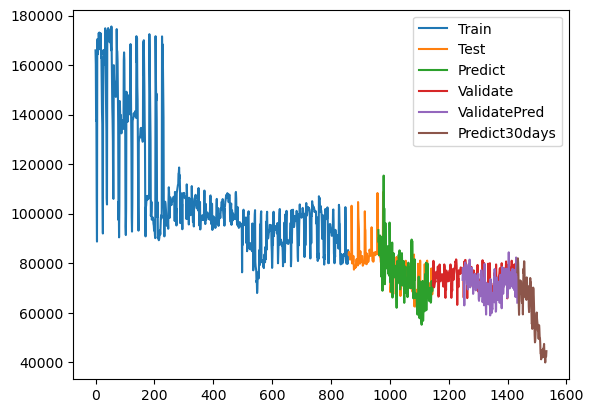

In [41]:
#  Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))

val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

prediect_data_index = pd.RangeIndex(start=len(data)-1, stop=len(data)+99, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))

plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict100days'])
plt.show()